In [54]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 81)
from sklearn.neighbors import KNeighborsRegressor
import scipy.stats
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns. set_style('darkgrid')
from pycaret.regression import setup, compare_models
from sklearn.model_selection import KFold, cross_val_score

from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge, HuberRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [55]:
train0 = pd.read_csv('train.csv')
test0 = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [56]:
train0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [57]:
train0.isna().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

In [58]:
target = train0['SalePrice']
test_ids = test0['Id']
train1 = train0.drop(['Id', 'SalePrice'], axis=1)
test1 = test0.drop('Id', axis=1)
data1 = pd.concat([train1, test1], axis=0).reset_index(drop=True)
data1

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2915,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2916,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2917,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Un

In [59]:
data1.select_dtypes(np.number)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,21.0,1936,4,7,1970,1970,0.0,0.0,0.0,546.0,546.0,546,546,0,1092,0.0,0.0,1,1,3,1,5,0,NaN,0.0,0.0,0,0,0,0,0,0,0,6,2006
2915,160,21.0,1894,4,5,1970,1970,0.0,252.0,0.0,294.0,546.0,546,546,0,1092,0.0,0.0,1,1,3,1,6,0,1970.0,1.0,286.0,0,24,0,0,0,0,0,4,2006
2916,20,160.0,20000,5,7,1960,1996,0.0,1224.0,0.0,0.0,1224.0,1224,0,0,1224,1.0,0.0,1,0,4,1,7,1,1960.0,2.0,576.0,474,0,0,0,0,0,0,9,2006
2917,85,62.0,10441,5,5,1992,1992,0.0,337.0,0.0,575.0,912.0,970,0,0,970,0.0,1.0,1,0,3,1,6,0,NaN,0.0,0.0,80,32,0,0,0,0,700,7,2006


In [60]:
data2 = data1.copy()

In [61]:
data2['MSSubClass'] = data2['MSSubClass'].astype(str)

In [62]:
for column in [
    'Alley',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature'
]:
    data2[column] = data2[column].fillna("None")

In [63]:
for column in [
    'MSZoning',
    'Utilities',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Electrical',
    'KitchenQual',
    'Functional',
    'SaleType'
]:
    data2[column] = data2[column].fillna(data2[column].mode()[0])

In [64]:
data3 = data2.copy()

In [65]:
data3.loc[data3['LotFrontage'].isna() == False, 'LotFrontage']

0        65.0
1        80.0
2        68.0
3        60.0
4        84.0
        ...  
2914     21.0
2915     21.0
2916    160.0
2917     62.0
2918     74.0
Name: LotFrontage, Length: 2433, dtype: float64

In [66]:
def knn_impute(df, na_target):
    df = df.copy()
    
    numeric_df = df.select_dtypes(np.number)
    non_na_columns = numeric_df.loc[: ,numeric_df.isna().sum() == 0].columns
    
    y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target]
    X_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns]
    X_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns]
    
    knn = KNeighborsRegressor()    
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    df.loc[df[na_target].isna() == True, na_target] = y_pred
    
    return numeric_df

In [67]:
for column in [
    'LotFrontage',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',
    'BsmtFullBath',
    'BsmtHalfBath',
    'GarageYrBlt',
    'GarageCars',
    'GarageArea'
]:
    data3 = knn_impute(data3, column)

In [68]:
data3.isna().sum()

LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
dtype: int64

In [69]:
data4 = data3.copy()

In [70]:
skew_df = pd.DataFrame(data4.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data4[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x > 0.5 else False)
skew_df

,Feature,Skew,Absolute Skew,Skewed
0,LotFrontage,1.340751,1.340751,True
1,LotArea,12.822431,12.822431,True
2,OverallQual,0.197110,0.197110,False
3,OverallCond,0.570312,0.570312,True
4,YearBuilt,-0.599806,0.599806,True
5,YearRemodAdd,-0.451020,0.451020,False
6,MasVnrArea,2.603682,2.603682,True
7,BsmtFinSF1,1.425516,1.425516,True
8,BsmtFinSF2,4.146111,4.146111,True
9,BsmtUnfSF,0.919322,0.919322,True


In [71]:
for column in skew_df.query('Skewed == True')['Feature'].values:
    data4[column] = np.log1p(data4[column])

In [72]:
data4['MoSold'].unique()

array([ 2,  5,  9, 12, 10,  8, 11,  4,  1,  7,  3,  6], dtype=int64)

In [73]:
data4['MoSold']= (-np.cos(0.5236 * data4['MoSold']))

In [74]:
data4['MoSold']

0      -0.499998
1       0.866028
2      -0.000011
3      -0.499998
4      -1.000000
          ...   
2914    1.000000
2915    0.500004
2916   -0.000011
2917    0.866021
2918   -0.866032
Name: MoSold, Length: 2919, dtype: float64

In [75]:
data5 = data4.copy()

In [76]:
data5 = pd.get_dummies(data5)

In [77]:
data6 = data5.copy()

In [78]:
scaler = StandardScaler()
scaler.fit(data6)

data6 = pd.DataFrame(scaler.transform(data6), index=data6.index, columns=data6.columns)

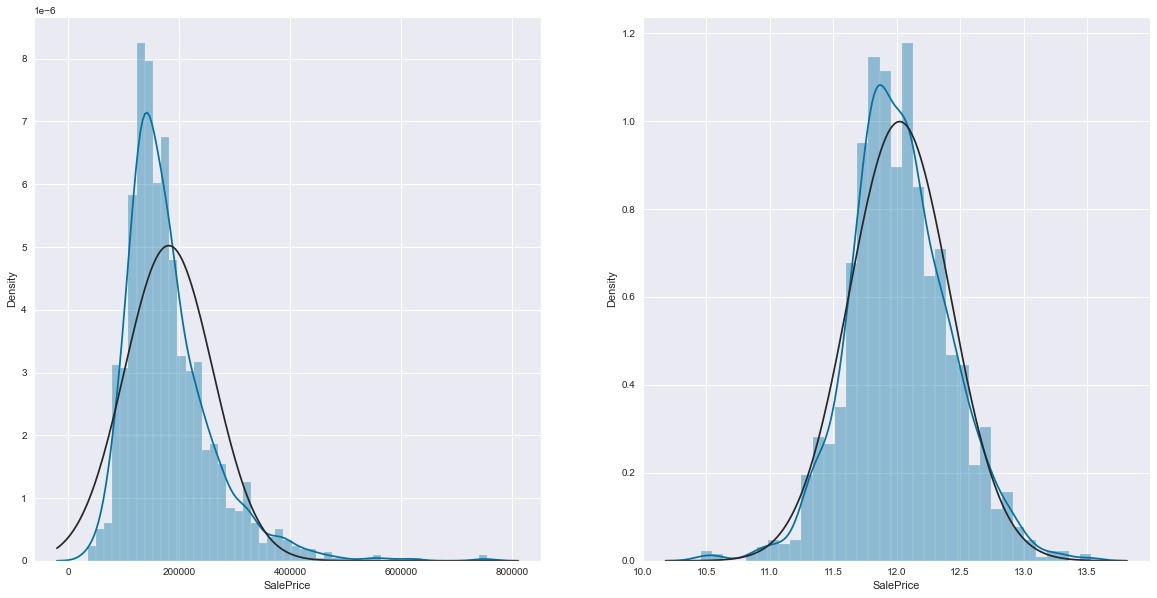

In [79]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.distplot(target, kde=True, fit=scipy.stats.norm)
plt.subplot(1, 2, 2)
sns.distplot(np.log(target), kde=True, fit=scipy.stats.norm)
plt.show()

In [80]:
log_target = np.log(target)

In [81]:
data7 = data6.copy()

In [82]:
train_final = data7.loc[:train0.index.max(), :].copy()
test_final = data7.loc[train0.index.max() + 1:, :].reset_index(drop=True).copy()


In [83]:
clf = setup(data=pd.concat([train_final, log_target], axis=1), target='SalePrice')

,Description,Value
0,session_id,1525
1,Target,SalePrice
2,Original Data,"(1460, 36)"
3,Missing Values,False
4,Numeric Features,35
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1021, 35)"


In [84]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0886,0.0176,0.1301,0.8887,0.0100,0.0074,3.2770
huber,Huber Regressor,0.0939,0.0185,0.1341,0.8827,0.0103,0.0078,0.0130
ridge,Ridge Regression,0.0946,0.0187,0.1350,0.8811,0.0104,0.0079,0.0040
lr,Linear Regression,0.0946,0.0188,0.1350,0.8811,0.0104,0.0079,0.3490
lar,Least Angle Regression,0.0947,0.0188,0.1351,0.8809,0.0104,0.0079,0.0060
br,Bayesian Ridge,0.0948,0.0188,0.1351,0.8808,0.0104,0.0079,0.0050
gbr,Gradient Boosting Regressor,0.0933,0.0192,0.1350,0.8788,0.0104,0.0078,0.1150
lightgbm,Light Gradient Boosting Machine,0.0970,0.0202,0.1393,0.8722,0.0108,0.0081,0.0580
et,Extra Trees Regressor,0.0979,0.0211,0.1433,0.8664,0.0111,0.0082,0.1990
rf,Random Forest Regressor,0.1029,0.0232,0.1500,0.8536,0.0116,0.0086,0.2690


In [85]:
reg = GradientBoostingRegressor(random_state=0)
reg.fit(train_final, log_target)
reg.score(train_final, log_target)


0.9482613888300578

In [86]:
huber = HuberRegressor()
huber.fit(train_final, log_target)
huber.score(train_final, log_target)

0.883523418865566

In [87]:
br = BayesianRidge()
br.fit(train_final, log_target)
br.score(train_final, log_target)

0.8863666818412903

In [88]:
#Baseline Model

In [89]:
baseline_model = CatBoostRegressor(verbose=0)

In [90]:
baseline_model.fit(train_final, log_target)
baseline_model.score(train_final, log_target)

0.9865630468859028

In [91]:
kf = KFold(n_splits=10)

results = cross_val_score(baseline_model, train_final, log_target, scoring='neg_mean_squared_error', cv=kf)

In [92]:
results.mean()

-0.01651390303702185

In [93]:
np.exp(np.sqrt(np.mean(-results)))

1.1371287351542925

In [94]:
-results

array([0.01581391, 0.01122245, 0.01245329, 0.02737395, 0.02176917,
       0.01243097, 0.01568464, 0.01252914, 0.01754391, 0.01831759])

<Figure size 1152x720 with 0 Axes>

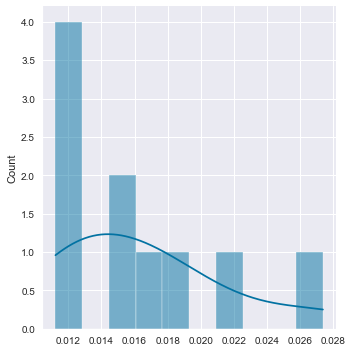

In [95]:
plt.figure(figsize=(16, 10))
sns.displot(-results, kde=True, bins=10)

In [96]:
final_predictions = np.exp(baseline_model.predict(test_final))

submission = pd.concat([test_ids, pd.Series(final_predictions, name='SalePrice')], axis=1)
submission

,Id,SalePrice
0,1461,128732.542479
1,1462,163907.750705
2,1463,188685.527875
3,1464,193545.197423
4,1465,190489.583210
...,...,...
1454,2915,77962.974390
1455,2916,85057.426092
1456,2917,182023.106813
1457,2918,114197.496859


In [97]:
sample_submission

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


In [98]:
submission.to_csv('./submission.csv', index=False, header=True)